# exp011 大外れ分析

予測誤差が大きいサンプルの特徴を分析し、改善の方向性を探る。

In [1]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 日本語フォント設定
plt.rcParams['font.family'] = 'Hiragino Sans'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# データ読み込み
outputs_dir = Path('../outputs')
features_path = list(outputs_dir.glob('run_mse_*/X_train.parquet'))[0]
X_train = pl.read_parquet(features_path)

oof_path = list(outputs_dir.glob('run_huber_*/oof_predictions.csv'))[0]
oof_df = pl.read_csv(oof_path)

actual = oof_df['actual'].to_numpy()
pred = oof_df['predicted'].to_numpy()
ape = np.abs(actual - pred) / actual * 100

print(f'サンプル数: {len(actual):,}')
print(f'Mean APE: {np.mean(ape):.2f}%')

サンプル数: 363,924
Mean APE: 12.17%


## 1. 誤差分布

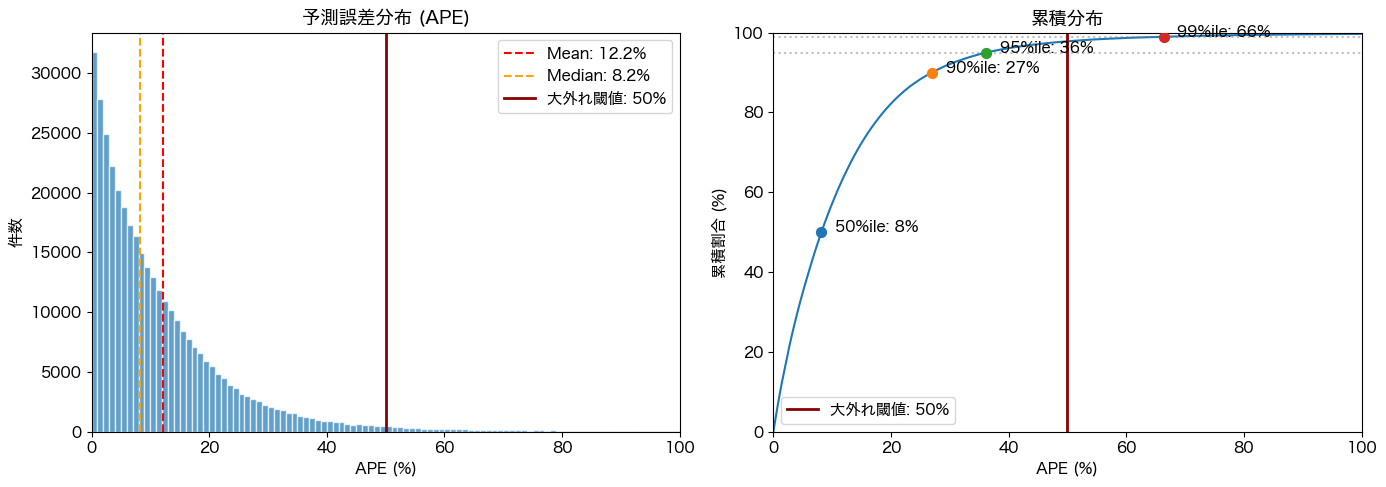


=== 誤差分布 ===
  50%ile: 8.2%
  75%ile: 16.1%
  90%ile: 26.9%
  95%ile: 36.2%
  99%ile: 66.3%

大外れ (APE>50%): 7,884件 (2.17%)


In [2]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左: APEヒストグラム
ax = axes[0]
ax.hist(ape, bins=100, range=(0, 100), edgecolor='white', alpha=0.7)
ax.axvline(np.mean(ape), color='red', linestyle='--', label=f'Mean: {np.mean(ape):.1f}%')
ax.axvline(np.median(ape), color='orange', linestyle='--', label=f'Median: {np.median(ape):.1f}%')
ax.axvline(50, color='darkred', linestyle='-', linewidth=2, label='大外れ閾値: 50%')
ax.set_xlabel('APE (%)')
ax.set_ylabel('件数')
ax.set_title('予測誤差分布 (APE)')
ax.legend()
ax.set_xlim(0, 100)

# 右: 累積分布
ax = axes[1]
sorted_ape = np.sort(ape)
cumulative = np.arange(1, len(sorted_ape) + 1) / len(sorted_ape) * 100
ax.plot(sorted_ape, cumulative)
ax.axhline(95, color='gray', linestyle=':', alpha=0.5)
ax.axhline(99, color='gray', linestyle=':', alpha=0.5)
ax.axvline(50, color='darkred', linestyle='-', linewidth=2, label='大外れ閾値: 50%')

# パーセンタイル表示
for p in [50, 90, 95, 99]:
    val = np.percentile(ape, p)
    ax.scatter([val], [p], s=50, zorder=5)
    ax.annotate(f'{p}%ile: {val:.0f}%', (val, p), textcoords='offset points', xytext=(10, 0))

ax.set_xlabel('APE (%)')
ax.set_ylabel('累積割合 (%)')
ax.set_title('累積分布')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.legend()

plt.tight_layout()
plt.show()

# 統計サマリー
print('\n=== 誤差分布 ===')
for p in [50, 75, 90, 95, 99]:
    print(f'  {p}%ile: {np.percentile(ape, p):.1f}%')
print(f'\n大外れ (APE>50%): {np.sum(ape > 50):,}件 ({np.sum(ape > 50)/len(ape)*100:.2f}%)')

## 2. 価格帯別の誤差

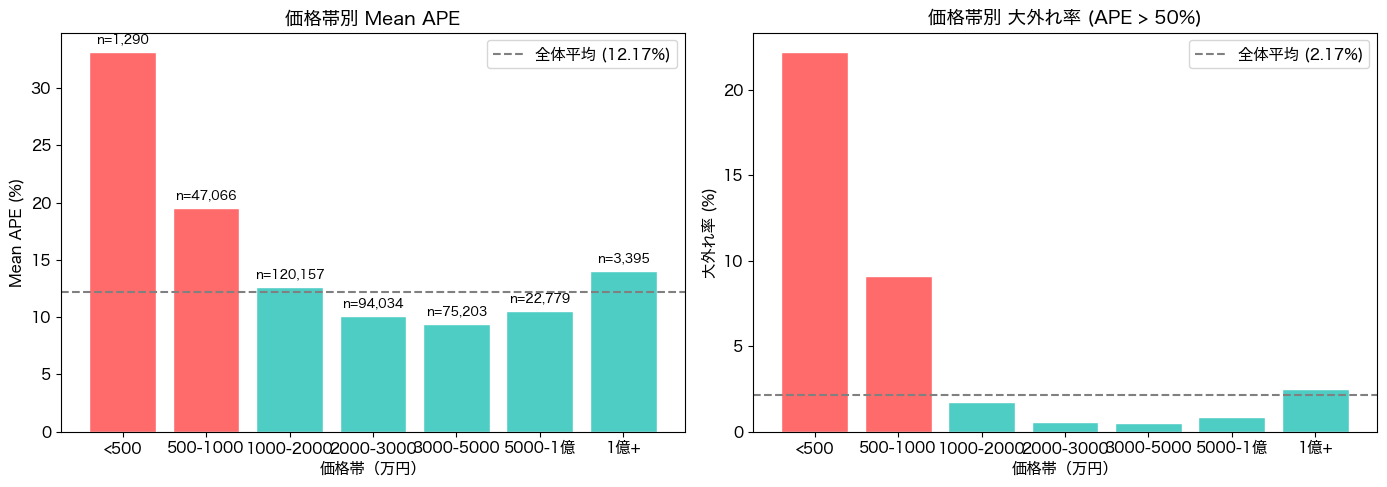


=== 価格帯別統計 ===
         価格帯 |       件数 |   Mean APE |       大外れ率
--------------------------------------------------
        <500 |    1,290 |      33.2% |      22.2%
    500-1000 |   47,066 |      19.6% |       9.1%
   1000-2000 |  120,157 |      12.6% |       1.8%
   2000-3000 |   94,034 |      10.1% |       0.6%
   3000-5000 |   75,203 |       9.4% |       0.5%
     5000-1億 |   22,779 |      10.5% |       0.9%
         1億+ |    3,395 |      14.0% |       2.5%


In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 価格帯定義（万円）
price_bins = [0, 500, 1000, 2000, 3000, 5000, 10000, 20000]
price_labels = ['<500', '500-1000', '1000-2000', '2000-3000', '3000-5000', '5000-1億', '1億+']

# 価格帯ごとの統計
stats = []
for i in range(len(price_bins) - 1):
    low, high = price_bins[i] * 10000, price_bins[i + 1] * 10000
    mask = (actual >= low) & (actual < high)
    if np.sum(mask) > 0:
        stats.append({
            'label': price_labels[i],
            'n': np.sum(mask),
            'mean_ape': np.mean(ape[mask]),
            'large_error_rate': np.sum(ape[mask] > 50) / np.sum(mask) * 100,
        })

labels = [s['label'] for s in stats]
mean_apes = [s['mean_ape'] for s in stats]
large_rates = [s['large_error_rate'] for s in stats]
counts = [s['n'] for s in stats]

# 左: Mean APE
ax = axes[0]
colors = ['#ff6b6b' if m > 15 else '#4ecdc4' for m in mean_apes]
bars = ax.bar(labels, mean_apes, color=colors, edgecolor='white')
ax.axhline(12.17, color='gray', linestyle='--', label='全体平均 (12.17%)')
ax.set_xlabel('価格帯（万円）')
ax.set_ylabel('Mean APE (%)')
ax.set_title('価格帯別 Mean APE')
ax.legend()

# 件数を棒の上に表示
for bar, n in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'n={n:,}', ha='center', va='bottom', fontsize=9)

# 右: 大外れ率
ax = axes[1]
colors = ['#ff6b6b' if r > 5 else '#4ecdc4' for r in large_rates]
bars = ax.bar(labels, large_rates, color=colors, edgecolor='white')
ax.axhline(2.17, color='gray', linestyle='--', label='全体平均 (2.17%)')
ax.set_xlabel('価格帯（万円）')
ax.set_ylabel('大外れ率 (%)')
ax.set_title('価格帯別 大外れ率 (APE > 50%)')
ax.legend()

plt.tight_layout()
plt.show()

# テーブル表示
print('\n=== 価格帯別統計 ===')
print(f'{"価格帯":>12} | {"件数":>8} | {"Mean APE":>10} | {"大外れ率":>10}')
print('-' * 50)
for s in stats:
    print(f'{s["label"]:>12} | {s["n"]:>8,} | {s["mean_ape"]:>9.1f}% | {s["large_error_rate"]:>9.1f}%')

## 3. 過大予測 vs 過小予測

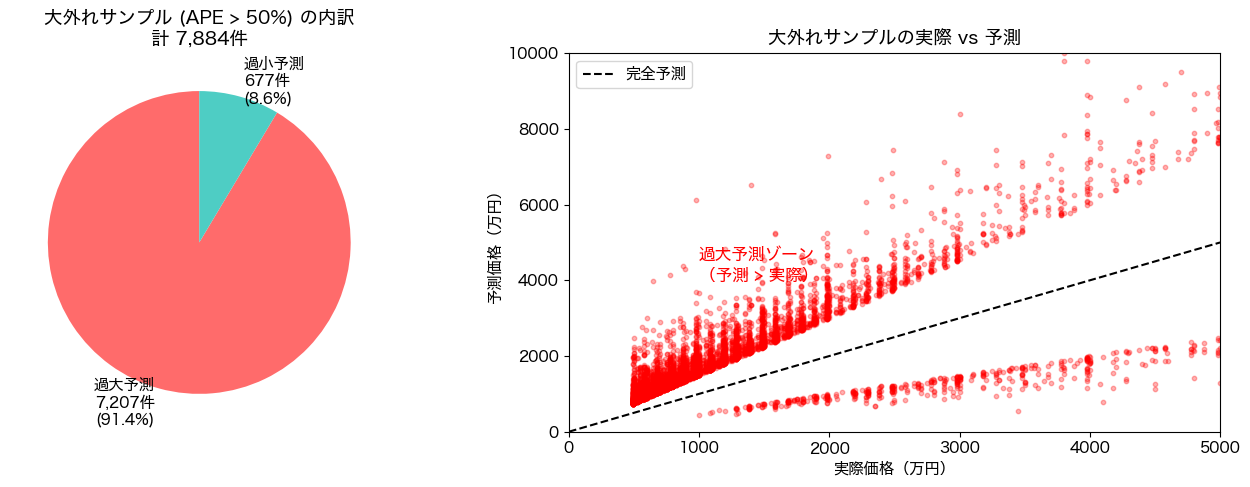


=== 過大予測パターン（大外れの91%）===
実際価格 中央値: 860万円
予測価格 中央値: 1510万円
予測/実際 比率: 1.66x


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 大外れサンプル
large_error_mask = ape > 50
over_pred = pred > actual
under_pred = pred < actual

# 左: 円グラフ（大外れの内訳）
ax = axes[0]
over_count = np.sum(large_error_mask & over_pred)
under_count = np.sum(large_error_mask & under_pred)
sizes = [over_count, under_count]
labels = [f'過大予測\n{over_count:,}件\n({over_count/(over_count+under_count)*100:.1f}%)', 
          f'過小予測\n{under_count:,}件\n({under_count/(over_count+under_count)*100:.1f}%)']
colors = ['#ff6b6b', '#4ecdc4']
ax.pie(sizes, labels=labels, colors=colors, autopct='', startangle=90)
ax.set_title(f'大外れサンプル (APE > 50%) の内訳\n計 {np.sum(large_error_mask):,}件')

# 右: 実際 vs 予測 散布図（大外れのみ）
ax = axes[1]
large_actual = actual[large_error_mask] / 10000  # 万円
large_pred = pred[large_error_mask] / 10000

ax.scatter(large_actual, large_pred, alpha=0.3, s=10, c='red')
ax.plot([0, 5000], [0, 5000], 'k--', label='完全予測')
ax.set_xlabel('実際価格（万円）')
ax.set_ylabel('予測価格（万円）')
ax.set_title('大外れサンプルの実際 vs 予測')
ax.set_xlim(0, 5000)
ax.set_ylim(0, 10000)
ax.legend()

# 過大予測の典型パターンを注釈
ax.annotate('過大予測ゾーン\n（予測 > 実際）', xy=(1000, 4000), fontsize=12, color='red')

plt.tight_layout()
plt.show()

# 統計
print('\n=== 過大予測パターン（大外れの91%）===')
over_mask = large_error_mask & over_pred
print(f'実際価格 中央値: {np.median(actual[over_mask])/10000:.0f}万円')
print(f'予測価格 中央値: {np.median(pred[over_mask])/10000:.0f}万円')
print(f'予測/実際 比率: {np.median(pred[over_mask]/actual[over_mask]):.2f}x')

## 4. 問題セグメントの特定

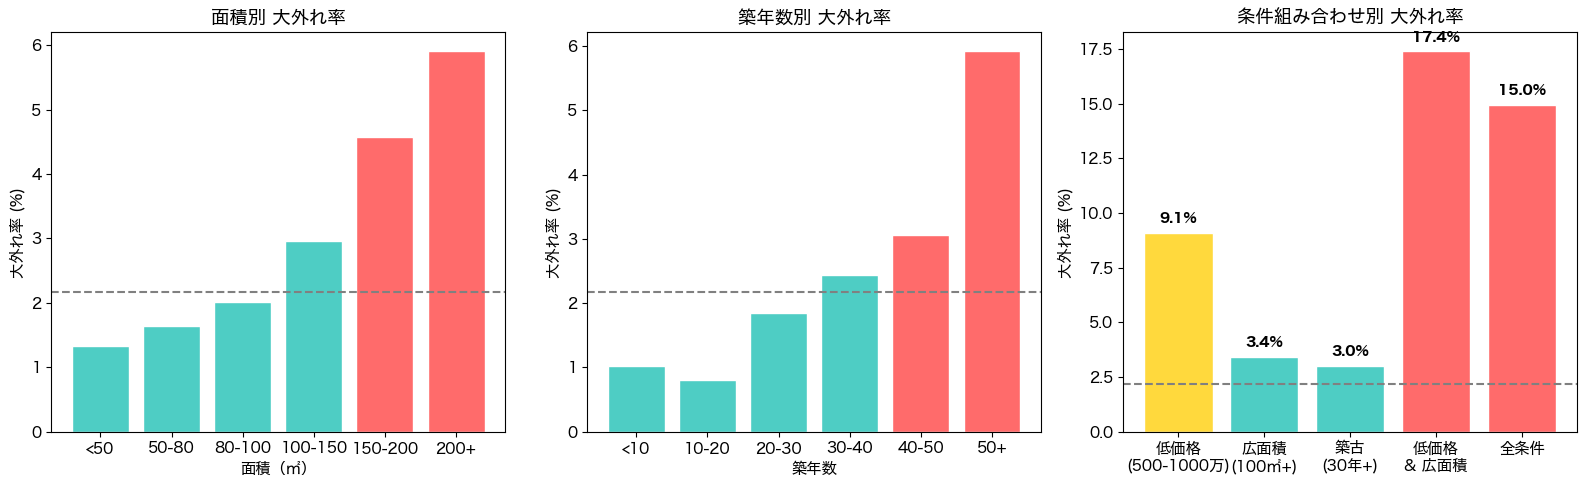

In [5]:
# 特徴量取得
house_area = X_train['house_area'].to_numpy()
building_age = X_train['building_age'].to_numpy()

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. 面積 vs APE
ax = axes[0]
area_bins = [0, 50, 80, 100, 150, 200, 500]
area_labels = ['<50', '50-80', '80-100', '100-150', '150-200', '200+']
area_stats = []
for i in range(len(area_bins) - 1):
    mask = (house_area >= area_bins[i]) & (house_area < area_bins[i + 1])
    if np.sum(mask) > 0:
        area_stats.append({
            'label': area_labels[i],
            'mean_ape': np.mean(ape[mask]),
            'large_rate': np.sum(ape[mask] > 50) / np.sum(mask) * 100,
        })

x = [s['label'] for s in area_stats]
y = [s['large_rate'] for s in area_stats]
colors = ['#ff6b6b' if v > 3 else '#4ecdc4' for v in y]
ax.bar(x, y, color=colors, edgecolor='white')
ax.axhline(2.17, color='gray', linestyle='--')
ax.set_xlabel('面積（㎡）')
ax.set_ylabel('大外れ率 (%)')
ax.set_title('面積別 大外れ率')

# 2. 築年数 vs APE
ax = axes[1]
age_bins = [0, 10, 20, 30, 40, 50, 100]
age_labels = ['<10', '10-20', '20-30', '30-40', '40-50', '50+']
age_stats = []
for i in range(len(age_bins) - 1):
    mask = (building_age >= age_bins[i]) & (building_age < age_bins[i + 1])
    if np.sum(mask) > 0:
        age_stats.append({
            'label': age_labels[i],
            'mean_ape': np.mean(ape[mask]),
            'large_rate': np.sum(ape[mask] > 50) / np.sum(mask) * 100,
        })

x = [s['label'] for s in age_stats]
y = [s['large_rate'] for s in age_stats]
colors = ['#ff6b6b' if v > 3 else '#4ecdc4' for v in y]
ax.bar(x, y, color=colors, edgecolor='white')
ax.axhline(2.17, color='gray', linestyle='--')
ax.set_xlabel('築年数')
ax.set_ylabel('大外れ率 (%)')
ax.set_title('築年数別 大外れ率')

# 3. 条件組み合わせ
ax = axes[2]
low_price = (actual >= 5000000) & (actual < 10000000)
large_area = house_area >= 100
old_building = building_age >= 30

conditions = [
    ('低価格\n(500-1000万)', low_price),
    ('広面積\n(100㎡+)', large_area),
    ('築古\n(30年+)', old_building),
    ('低価格\n& 広面積', low_price & large_area),
    ('全条件', low_price & large_area & old_building),
]

x = [c[0] for c in conditions]
y = [np.sum(ape[c[1]] > 50) / np.sum(c[1]) * 100 for c in conditions]
colors = ['#ff6b6b' if v > 10 else '#ffd93d' if v > 5 else '#4ecdc4' for v in y]
bars = ax.bar(x, y, color=colors, edgecolor='white')
ax.axhline(2.17, color='gray', linestyle='--', label='全体平均')
ax.set_ylabel('大外れ率 (%)')
ax.set_title('条件組み合わせ別 大外れ率')

# 値を棒の上に表示
for bar, v in zip(bars, y):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
            f'{v:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 5. ヒートマップ: 価格 × 面積

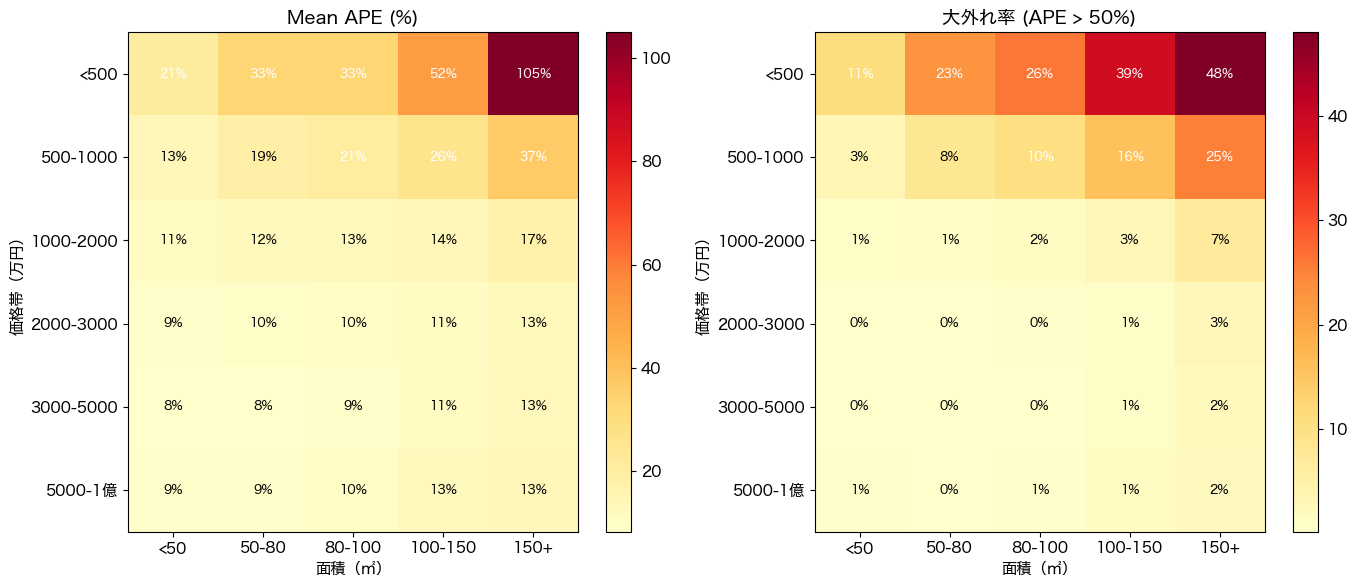


赤いセル（左下）が問題領域: 低価格 × 広面積


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 価格帯と面積帯
price_bins = [0, 500, 1000, 2000, 3000, 5000, 10000]
price_labels = ['<500', '500-1000', '1000-2000', '2000-3000', '3000-5000', '5000-1億']
area_bins = [0, 50, 80, 100, 150, 300]
area_labels = ['<50', '50-80', '80-100', '100-150', '150+']

# ヒートマップ用データ作成
heatmap_ape = np.zeros((len(price_labels), len(area_labels)))
heatmap_rate = np.zeros((len(price_labels), len(area_labels)))
heatmap_count = np.zeros((len(price_labels), len(area_labels)))

for i, (p_low, p_high) in enumerate(zip(price_bins[:-1], price_bins[1:])):
    for j, (a_low, a_high) in enumerate(zip(area_bins[:-1], area_bins[1:])):
        mask = ((actual >= p_low * 10000) & (actual < p_high * 10000) & 
                (house_area >= a_low) & (house_area < a_high))
        if np.sum(mask) > 0:
            heatmap_ape[i, j] = np.mean(ape[mask])
            heatmap_rate[i, j] = np.sum(ape[mask] > 50) / np.sum(mask) * 100
            heatmap_count[i, j] = np.sum(mask)

# 左: Mean APE ヒートマップ
ax = axes[0]
im = ax.imshow(heatmap_ape, cmap='YlOrRd', aspect='auto')
ax.set_xticks(range(len(area_labels)))
ax.set_xticklabels(area_labels)
ax.set_yticks(range(len(price_labels)))
ax.set_yticklabels(price_labels)
ax.set_xlabel('面積（㎡）')
ax.set_ylabel('価格帯（万円）')
ax.set_title('Mean APE (%)')
plt.colorbar(im, ax=ax)

# 値を表示
for i in range(len(price_labels)):
    for j in range(len(area_labels)):
        if heatmap_count[i, j] > 0:
            text = f'{heatmap_ape[i, j]:.0f}%'
            color = 'white' if heatmap_ape[i, j] > 20 else 'black'
            ax.text(j, i, text, ha='center', va='center', color=color, fontsize=9)

# 右: 大外れ率 ヒートマップ
ax = axes[1]
im = ax.imshow(heatmap_rate, cmap='YlOrRd', aspect='auto')
ax.set_xticks(range(len(area_labels)))
ax.set_xticklabels(area_labels)
ax.set_yticks(range(len(price_labels)))
ax.set_yticklabels(price_labels)
ax.set_xlabel('面積（㎡）')
ax.set_ylabel('価格帯（万円）')
ax.set_title('大外れ率 (APE > 50%)')
plt.colorbar(im, ax=ax)

# 値を表示
for i in range(len(price_labels)):
    for j in range(len(area_labels)):
        if heatmap_count[i, j] > 0:
            text = f'{heatmap_rate[i, j]:.0f}%'
            color = 'white' if heatmap_rate[i, j] > 10 else 'black'
            ax.text(j, i, text, ha='center', va='center', color=color, fontsize=9)

plt.tight_layout()
plt.show()

print('\n赤いセル（左下）が問題領域: 低価格 × 広面積')

## 6. 大外れ Top 20

In [7]:
# Top 20 大外れ
sorted_idx = np.argsort(ape)[::-1][:20]

print('=== 大外れ Top 20 ===')
print(f'{"No":>3} | {"APE":>6} | {"実際(万)":>10} | {"予測(万)":>10} | {"面積":>6} | {"築年":>5}')
print('-' * 60)

for rank, idx in enumerate(sorted_idx, 1):
    a = actual[idx] / 10000
    p = pred[idx] / 10000
    e = ape[idx]
    area = house_area[idx]
    age = building_age[idx]
    age_str = f'{age:.0f}' if not np.isnan(age) else 'N/A'
    print(f'{rank:>3} | {e:>5.0f}% | {a:>10,.0f} | {p:>10,.0f} | {area:>6.0f} | {age_str:>5}')

print('\n=== 共通パターン ===')
print('- 広面積（100〜2600㎡）の物件')
print('- 低価格（500〜1400万円）')
print('- → 田舎の広い一軒家を都市部相場で過大予測')

=== 大外れ Top 20 ===
 No |    APE |      実際(万) |      予測(万) |     面積 |    築年
------------------------------------------------------------
  1 |   524% |        980 |      6,115 |    305 |    24
  2 |   513% |        650 |      3,983 |    111 |    46
  3 |   429% |        780 |      4,130 |    220 |    30
  4 |   401% |        600 |      3,009 |     77 |    24
  5 |   399% |        498 |      2,483 |    613 |    86
  6 |   398% |        880 |      4,380 |    119 |    86
  7 |   392% |        560 |      2,754 |    116 |   N/A
  8 |   383% |        888 |      4,288 |   1711 |    38
  9 |   366% |      1,400 |      6,519 |     87 |    31
 10 |   354% |        595 |      2,700 |   2642 |    26
 11 |   351% |        498 |      2,244 |    175 |     0
 12 |   338% |        498 |      2,182 |    175 |     0
 13 |   322% |        580 |      2,449 |    467 |    58
 14 |   318% |        500 |      2,089 |    262 |    35
 15 |   317% |        500 |      2,085 |    263 |    35
 16 |   315% |        65

## 7. サマリーと改善案

/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_88215/1814412579.py:50: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_88215/1814412579.py:50: UserWarning: Glyph 22806 (\N{CJK UNIFIED IDEOGRAPH-5916}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_88215/1814412579.py:50: UserWarning: Glyph 12428 (\N{HIRAGANA LETTER RE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_88215/1814412579.py:50: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_88215/1814412579.py:50: UserWarning: Glyph 26512 (\N{CJK UNIFIED IDEOGRAPH-6790}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/va

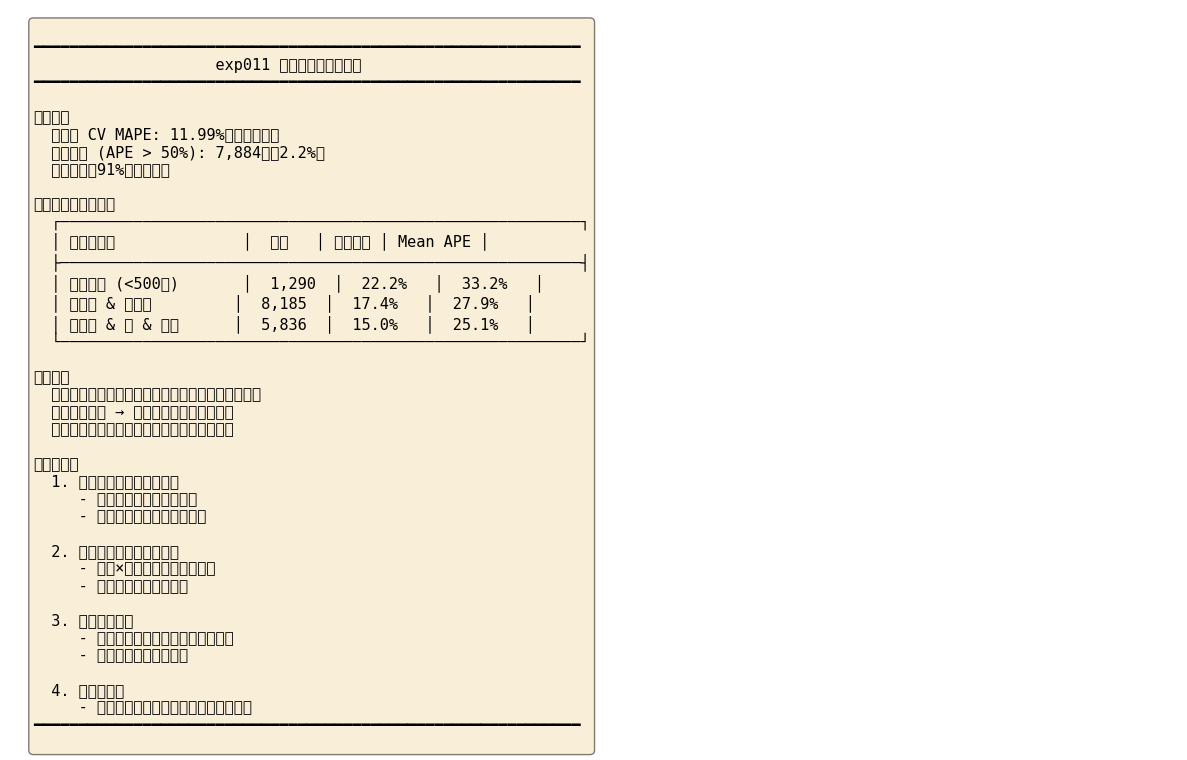

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('off')

summary_text = """
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
                    exp011 大外れ分析サマリー
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

【現状】
  ・全体 CV MAPE: 11.99%（単純平均）
  ・大外れ (APE > 50%): 7,884件（2.2%）
  ・大外れの91%が過大予測

【問題セグメント】
  ┌─────────────────────────────────────────────────────────┐
  │ セグメント              │  件数   │ 大外れ率 │ Mean APE │
  ├─────────────────────────────────────────────────────────┤
  │ 超低価格 (<500万)       │  1,290  │  22.2%   │  33.2%   │
  │ 低価格 & 広面積         │  8,185  │  17.4%   │  27.9%   │
  │ 低価格 & 広 & 築古      │  5,836  │  15.0%   │  25.1%   │
  └─────────────────────────────────────────────────────────┘

【原因】
  ・田舎の広い安価な物件を、都市部相場で過大予測
  ・面積が広い → 高価格と学習してしまう
  ・地域の価格水準を十分に捉えられていない

【改善案】
  1. 地域セグメント別モデル
     - 都市部と地方で別モデル
     - 地価公示データの活用強化

  2. 面積あたり単価の特徴量
     - 地域×物件タイプ別の㎡単価
     - 面積対数変換や二乗項

  3. 予測の後処理
     - 低価格帯物件に予測上限を設ける
     - 異常予測の検出と補正

  4. 外れ値除外
     - 学習データから極端なサンプルを除外
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
"""

ax.text(0.02, 0.98, summary_text, transform=ax.transAxes, 
        fontsize=11, verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()